# METR 3123 HW \#3 – Due Monday March 21 at 9 PM.


### This is the jupyter notebook for our 3rd homework assignment.

---

### About our programming framework

Jupyter is a web-based interactive coding framework that many use as their primary programming platform, because its block formatting caters very well to debugging, while the blocks can be a mix of text (like this one), code, and figures.

Please watch the first 3 minutes of this great [tutorial](https://www.youtube.com/watch?v=HW29067qVWk) on jupyter as an intro. While the remainder of that video covers how to install jupyter on your own machine, *you are not required to install anything for this programming assignment.* This is an online, fully self-contained approach called **Binder**, which removes the need for installing any software. The **Binder** is a carbon copy of our [class Github repository](https://github.com/jhruppert/OU-Dynamics-3123), though what you modify here will not change the github repository.

There are important caveats to this online framework: Because Binder does not save your changes and sessions expire after 10 min of idle time, **I strongly recommend you save local copies of your notebook or copy&paste the code you modify into some place you can retrieve it.**

To run code, click on a code block to highlight it, then run it by pressing the Play button in the toolbar (or learn some [keyboard shortcuts](https://gist.github.com/discdiver/9e00618756d120a8c9fa344ac1c375ac)). Do the same thing progressing down the notebook in sequence. In this way, any code error will usually be contained to whichever block you're modifying.

___

### The Assignment

We are going to more deeply examine the intense late-January 2022 winter storm that we consdered in Exam 1, which was associated with a very pronounced upper-level trough/ridge pattern and highly ageostrophic flow.

The code blocks below are already set up to read in the data and plot some simple horizontal maps.

**What you will do:** you will modify and add to this code to produce horizontal maps for the 300-hPa level of:
1. Geostrophic wind
2. Ageostrophic wind
3. Divergence
4. Relative vorticity

Each of these calculations will lean heavily on the Python function numpy.gradient

---

In [1]:
# load necessary packages:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import cartopy

The below command lists the contents of the data directory (7 netcdf files):

In [2]:
!ls data/jan2022/

ERA5-jan2022-pl_1000.nc ERA5-jan2022-pl_300.nc  ERA5-jan2022-pl_850.nc
ERA5-jan2022-pl_200.nc  ERA5-jan2022-pl_500.nc


Each file is a separate pressure level (the numbers in the filename are hPa), containing the following:
- 16 time steps (dt = 6 h), starting at 0000 UTC 27 Oct 2012
- With the variables:
    - "u" - zonal wind (m/s)
    - "v" - meridional ...
    - "w" - vertical ...
    - "t" - temperature (K)
    - "z" - geopotential ($m^2/s^2$)

In the below blocks, you'll find variables that you can modify to change the desired pressure level (changes the input file) and time step to plot.

Note: when read in, variables are organized as $(y, x)$

In [3]:
pressure = '300' # select the pressure level to plot
nc = Dataset('data/jan2022/ERA5-jan2022-pl_'+pressure+'.nc') # this opens the netcdf file

In [4]:
# Read in some essential variables

itime = 10 # choose index of time

# horizontal wind components
u = nc.variables['u'][itime, :, :] # result is 2d array (lat, lon), m/s
v = nc.variables['v'][itime, :, :]

# geopotential
phi = nc.variables['z'][itime, :, :] # m2/s2

# Need one-dimensional lat/lon grids for gradient operation
lon1d = nc.variables['longitude'][:]
lat1d = nc.variables['latitude'][:]

# make 2d lat, lon grid to match variable dimensions for plotting
lat, lon = np.meshgrid(nc.variables['latitude'][:], nc.variables['longitude'][:], indexing='ij')

#### Calculate the geostrophic and ageostrophic winds:

$u_g=-\dfrac{1}{f}\dfrac{\partial \phi}{\partial y}$ and $v_g=\dfrac{1}{f}\dfrac{\partial \phi}{\partial x}$

Note that, because we're doing calculations on the globe, we must deal with spherical coordinates:

$\partial y \rightarrow a\partial \Phi$ and $\partial x \rightarrow a \text{cos}(\Phi) \partial \lambda$, where $\Phi$ is latitude (using uppercase to distinguish from geopotential), $\lambda$ is longitude, and $a$ is Earth radius.

We may then simply write $u=u_g+u_a$, and therefore $u_a=u-u_g$ (same for $v_a$).

In [5]:
# Necessary constants
omeg = 7.292e-5 # Earth angular velocity, rad/s
ny = np.size(nc.variables['latitude'][:])
deg2rad = np.pi/180.
a = 6371e3 # earth radius [m]
latlonkm  = a*np.pi/180 # a * 1deg * Pi / 180deg = length of 1 deg latitude in km
ilatlonkm = 1./latlonkm # inverse

In [6]:
# Geopotential gradient
gradphi = np.gradient(phi,lat1d,lon1d) # gradient of phi WRT both lat and lon
# See what this looks like:
print(np.shape(gradphi))

# Run latitude loop for Coriolis parameter and d(Phi)
ug=gradphi[0]*ilatlonkm # Initialize ug and vg and modify in loop
vg=gradphi[1]*ilatlonkm
for iy in range(ny):
    ilat = lat1d[iy]
    f = 2*omeg*np.sin(ilat * deg2rad)
    # Some print statements to test that things are working:
    # print("Lat =",ilat)
    # print(f)
    # print("cos(lat) =",np.cos(ilat * deg2rad))
    # print( )
    # If statements to take care of divide-by-zeros
    if ilat > 0:
        if ilat < 90:
            ug[iy,:] *= -1. / f
        else:
            ug[iy,:] = np.nan
        vg[iy,:] *= 1. / (f * np.cos(ilat * deg2rad))
    else:
        ug[iy,:] = np.nan
        vg[iy,:] = np.nan



(2, 361, 441)


#### Calculate divergence and vorticity:

Next, calculate the divergence and relative vorticity:

$\text{Div}=\nabla \cdot \vec{V}$ and $\zeta=\hat k \cdot \nabla \times \vec{U}$

#### Plotting routines:

/Users/jruppert/opt/anaconda3/envs/metr3123/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'projection'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/Users/jruppert/opt/anaconda3/envs/metr3123/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: The following kwargs were not used by contour: 'projection'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


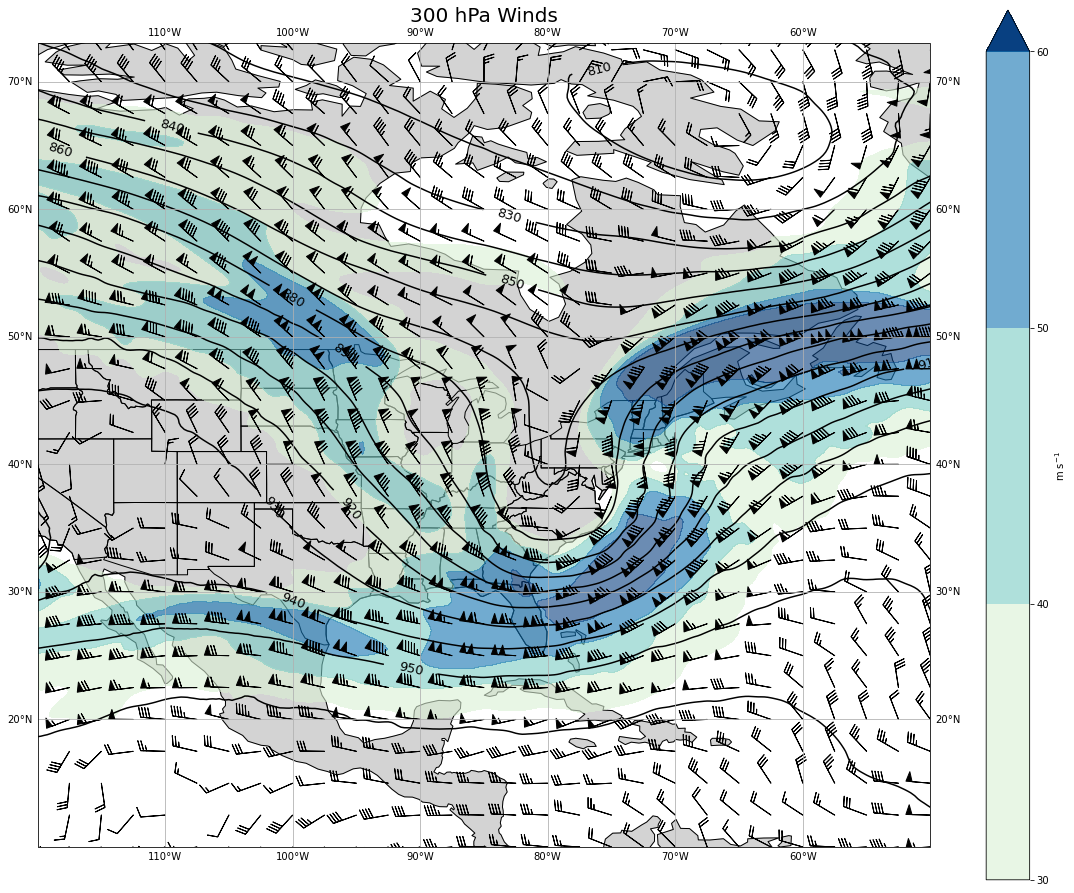

In [7]:
# select plotting area
plt_area=[-120, -50, 10, 70] # W,E,S,N

spacing=10 #barbspacing (smaller if zoomed in)

# create figure
fig = plt.figure(figsize=(20,16))
ax = fig.add_subplot(111,projection=cartopy.crs.PlateCarree())
ax.set_title(pressure + ' hPa Winds', fontsize=20)

# fill contour for wind speed (jet streaks)
# wind speed in m/s
spd = np.sqrt(u**2 + v**2)
clevs_spd = np.arange(30, 70, 10)
im = ax.contourf(lon, lat, spd, clevs_spd, cmap='GnBu', alpha=0.6, \
                 extend='max',projection=cartopy.crs.PlateCarree(), zorder=2)
cbar = plt.colorbar(im, ax=ax); cbar.ax.set_ylabel('m s$^{-1}$')

# line contours of geopotential height (in black)
g=9.81 # m/s^2
geoz = phi / g / 10 # m2/s2 --> m --> dam
clevs_phi = np.arange(800, 1000, 10) # may need to adapt these for the pressure level
im = ax.contour(lon, lat, geoz, clevs_phi, colors='black', projection=cartopy.crs.PlateCarree(), zorder=2)
ax.clabel(im, im.levels, inline=True, fontsize=13)

# additional contours (in red)
# cvar = 
# dd = ax.contour(lon, lat, cvar*1e5, np.arange(-200, 200, 10), colors='red', projection=cartopy.crs.PlateCarree(), zorder=2)
# ax.clabel(dd, dd.levels, inline=True, fontsize=13)

# wind barbs
mps_to_kts=1.94384 # conversion factor from m/s to knots for barbs
uplt = u * mps_to_kts
vplt = v * mps_to_kts
# mask for speeds < 10 kts
spd = np.sqrt(uplt**2+vplt**2)
uplt[np.where(spd < 10)] = np.nan
ax.barbs(lon[::spacing,::spacing], lat[::spacing,::spacing], uplt[::spacing,::spacing], vplt[::spacing,::spacing], zorder=2)

# add map features
ax.add_feature(cartopy.feature.LAND,facecolor="lightgray") #land color
# ax.add_feature(cartopy.feature.OCEAN) #ocean color
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.STATES)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# Zoom into selected area (comment this out to plot entire available area)
ax.set_extent(plt_area)

plt.show()